In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Use-Case")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Use-Case]


## 멀티 에이전트 감독자(Multi-Agent Supervisor)

LangGraph를 활용하여 다중 에이전트 시스템을 구축하고, 에이전트 간 작업을 효율적으로 조정하고 감독자(Supervisor)를 통해 관리하는 방법입니다.  
여러 에이전트를 동시에 다루며, 각 에이전트가 자신의 역하를 수행하도록 관리하고, 작업 완료 시 결과를 처리하는 방법을 다룹니다.  

멀티 에이전트 감독자의 특징은 다음과 같습니다:

- Supervisor는 다양한 전문 에이전트를 한 데 모아, 하나의 팀으로 운영하는 역할을 합니다. 
- Supervisor 에이전트는 팀의 진행상황을 관찰하고, 각 단계별로 적절한 에이전트를 호출하거나 작업을 종료하는 등의 로직을 수행합니다.

##### 참고자료

- [LangGraph Supervisor](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor)
- [create_react_agent 함수 문서화](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)

##### 그래프 흐름

![multi_agent_supervisor](./assets/langgraph_use_case_multi_agent_supervisor.png)

### 기능 구현

#### 모델 정의

In [3]:
from models import get_model_name, LLMs

# 모델명 정의
MODEL_NAME = get_model_name(LLMs.GPT4o)
print(MODEL_NAME)

gpt-4o


#### 상태 정의

In [9]:
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # 메시지
    next: str  # 다음으로 라우팅할 에이전트

#### 도구 생성

In [4]:
from tools_tavily import TavilySearch
from langchain_experimental.tools import PythonREPLTool

# 최대 5개의 검색 결과를 반환하는 Tavily 검색 도구 초기화
tavily_tool = TavilySearch(max_results=5)

# 로컬에서 코드를 실행하는 Python REPL 도구 초기화 (안전하지 않을 수 있음)
python_repl_tool = PythonREPLTool()

#### Agent 생성하는 Utility 함수 구현

아래 `agent_node` 함수는 에이전트들을 실행할 때 공통으로 사용할 수 있는 함수입니다. 

In [5]:
from langchain_core.messages import HumanMessage


# 지정한 agent와 name을 사용하여 agent 노드를 생성
def agent_node(state, agent, name):
    # agent 호출
    agent_response = agent.invoke(state)
    # agent의 마지막 메시지를 HumanMessage로 변환하여 반환
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

`agent_node`를 활용하여 node 를 생성할때 `functools.partial` 을 활용하여 node를 생성할 수 있습니다.

In [6]:
import functools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI


# Research Agent 생성
research_agent = create_react_agent(ChatOpenAI(model="gpt-4o"), tools=[tavily_tool])

# research node 생성
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

노드의 작동을 확인합니다.

In [10]:
research_node(
    AgentState(
        messages=HumanMessage(content="Code hello world and print it to the terminal")
    )
)

{'messages': [HumanMessage(content='To print "Hello, World!" to the terminal, you can use different programming languages. Here are a few examples:\n\n### Python\n```python\nprint("Hello, World!")\n```\n\n### JavaScript (Node.js)\n```javascript\nconsole.log("Hello, World!");\n```\n\n### Java\n```java\npublic class HelloWorld {\n    public static void main(String[] args) {\n        System.out.println("Hello, World!");\n    }\n}\n```\n\n### C\n```c\n#include <stdio.h>\n\nint main() {\n    printf("Hello, World!\\n");\n    return 0;\n}\n```\n\n### C++\n```cpp\n#include <iostream>\n\nint main() {\n    std::cout << "Hello, World!" << std::endl;\n    return 0;\n}\n```\n\n### Bash\n```bash\necho "Hello, World!"\n```\n\nYou can choose any of these examples based on the programming language you are working with.', additional_kwargs={}, response_metadata={}, name='Researcher')]}

#### Agent Supervisor 생성

에이전트를 관리 감독하는 감독자 에이전트를 생성합니다.

In [11]:
from pydantic import BaseModel
from typing import Literal

# 멤버 Agent 목록 정의
members = ["Researcher", "Coder"]

# 다음 작업자 선택 옵션 목록 정의
options_for_next = ["FINISH"] + members


# 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

In [12]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


# 시스템 프롬프트 정의: 작업자 간의 대화를 관리하는 감독자 역할
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# ChatPromptTemplate 생성
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)


# Supervisor Agent 생성
def supervisor_agent(state):
    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    # Agent 호출
    return supervisor_chain.invoke(state)

### 그래프 정의

#### 1. 노드 정의

In [13]:
import functools
from langgraph.prebuilt import create_react_agent


# Research Agent 생성
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""


# Coder Agent 생성
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=code_system_prompt,
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

#### 2. 엣지 설정 및 그래프 컴파일

In [14]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(AgentState)

# 그래프에 노드 추가
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)


# 멤버 노드 > Supervisor 노드로 엣지 추가
for member in members:
    workflow.add_edge(member, "Supervisor")

# 조건부 엣지 추가 (
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END


def get_next(state):
    return state["next"]


# Supervisor 노드에서 조건부 엣지 추가
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# 시작점
workflow.add_edge(START, "Supervisor")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

#### 3. 그래프 시각화

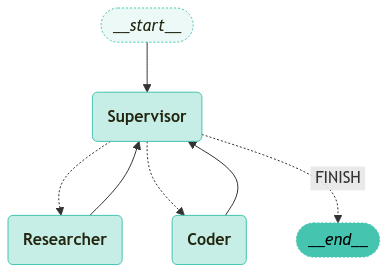

In [16]:
from graphs import visualize_graph

visualize_graph(graph, xray=True)

#### 실행(팀호출)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_b4TQcf4TXjsDSrjr3O1C0pbV)
 Call ID: call_b4TQcf4TXjsDSrjr3O1C0pbV
  Args:
    query: 2024 Bitcoin monthly price forecast

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "Bitcoin Price Prediction 2024, 2025, Long-term (BTC) Forecast for 2026-2030", "url": "https://cryptopricesprediction.com/bitcoin-btc-price-prediction-2025-2030", "content": "Bitcoin Price Prediction Bitcoin (BTC) Price Prediction 2025-2030 Bitcoin (BTC) Price Prediction 2025-2030 Initially, from September 2024 to December 2024, Bitcoin began with a predicted price of $69,085.97, ex

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_PngjEWN07nUFY2ZqCiiBnFWm)
 Call ID: call_PngjEWN07nUFY2ZqCiiBnFWm
  Args:
    query: import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 데이터 설정
months = ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']
prices = [83500, 86500, 88750, 86000, 88000, 91500, 93500, 96000, 100000, 105000, 110000, 86500]

# 폰트 설정
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams

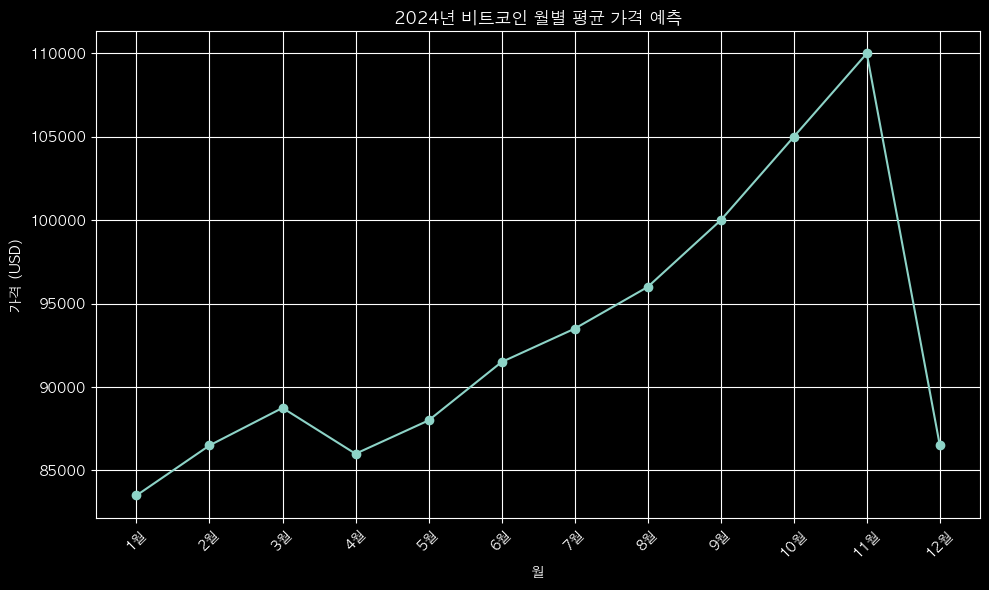


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

Here is the graph showing the forecasted average monthly prices of Bitcoin for the year 2024. Please note that these are speculative estimates and actual prices may vary significantly.

🔄 Node: Coder 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: Coder

Here is the graph showing the forecasted average monthly prices of Bitcoin for the year 2024. Please note that these are speculative estimates and actual prices may vary significantly.

🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
FINISH


In [18]:
from langchain_core.runnables import RunnableConfig
from langchain_print import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2024년 1월부터 12월까지 비트코인 월별 가격을 그래프로 그려주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(graph, inputs, config)